/opt/conda/lib/python3.10/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9912422/9912422 [00:02<00:00, 4787199.39it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28881/28881 [00:00<00:00, 169682.55it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1648877/1648877 [00:01<00:00, 1525957.89it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4542/4542 [00:00<00:00, 2483771.68it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

49.82949242350261
43.14585705159505
41.45578091023763
40.67297941894531
40.27086883544922
40.03910866292318
39.86456780192057
39.704177541097
39.624544122314454
39.499897593180336
39.42754281819661
39.365796854654945
39.29701616617839
39.27498920288086
39.20627747395833
39.13727860514323
39.078321761067706
39.07202969360352
38.99887813110352
38.98974208984375
38.974793418375654
38.95705331624349
38.938405771891276
38.90169922587077
38.882675103759766
38.87132270304362
38.85355082397461
38.79939309285482
38.81984985555013
38.823030938720706


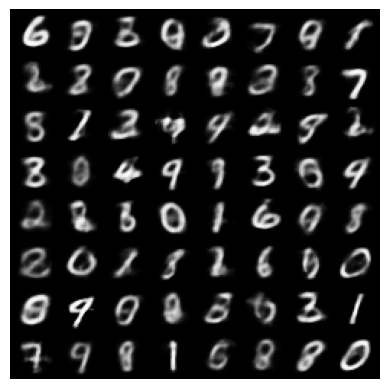

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms


# hyperparameters
input_dim = 784  # mnist image 28x28
hidden_dim = 100
latent_dim = 20
epochs = 30
learning_rate = 1e-3
batch_size = 32


class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, hidden_dim)
        self.linear_mu = nn.Linear(hidden_dim, latent_dim)
        self.linear_logvar = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        h = self.linear(x)
        h = F.relu(h)
        mu = self.linear_mu(h)
        logvar = self.linear_logvar(h)
        sigma = torch.exp(0.5 * logvar)
        return mu, sigma


class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim, use_sigmoid=False):
        super().__init__()
        self.linear1 = nn.Linear(latent_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, output_dim)
        self.use_sigmoid = use_sigmoid

    def forward(self, z):
        h = self.linear1(z)
        h = F.relu(h)
        h = self.linear2(h)
        if self.use_sigmoid:
            h = F.sigmoid(h)
        return h


def reparameterize(mu, sigma):
    eps = torch.randn_like(sigma)
    z = mu + eps * sigma
    return z


class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.encoder1 = Encoder(input_dim, hidden_dim, latent_dim)
        self.encoder2 = Encoder(latent_dim, hidden_dim, latent_dim)
        self.decoder1 = Decoder(latent_dim, hidden_dim, input_dim, use_sigmoid=True)
        self.decoder2 = Decoder(latent_dim, hidden_dim, latent_dim)

    def get_loss(self, x):
        mu1, sigma1 = self.encoder1(x)
        z1 = reparameterize(mu1, sigma1)
        mu2, sigma2 = self.encoder2(z1)
        z2 = reparameterize(mu2, sigma2)

        z_hat = self.decoder2(z2)
        x_hat = self.decoder1(z1)

        # loss
        batch_size = len(x)
        L1 = F.mse_loss(x_hat, x, reduction='sum')
        L2 = - torch.sum(1 + torch.log(sigma2 ** 2) - mu2 ** 2 - sigma2 ** 2)
        L3 = - torch.sum(1 + torch.log(sigma1 ** 2) - (mu1 - z_hat) ** 2 - sigma1 ** 2)
        return (L1 + L2 + L3) / batch_size


# dataset
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Lambda(torch.flatten)
            ])
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

model = VAE(input_dim, hidden_dim, latent_dim)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(epochs):
    loss_sum = 0.0
    cnt = 0

    for x, label in dataloader:
        optimizer.zero_grad()
        loss = model.get_loss(x)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        cnt += 1

    loss_avg = loss_sum / cnt
    print(loss_avg)


 # visualize generated images
with torch.no_grad():
    sample_size = 64
    z2 = torch.randn(sample_size, latent_dim)
    z1_hat = model.decoder2(z2)
    z1 = reparameterize(z1_hat, torch.ones_like(z1_hat))
    x = model.decoder1(z1)
    generated_images = x.view(sample_size, 1, 28, 28)

grid_img = torchvision.utils.make_grid(generated_images, nrow=8, padding=2, normalize=True)

plt.imshow(grid_img.permute(1, 2, 0))
plt.axis('off')
plt.show()